In [1]:
# Standard libraries
import pandas as pd
import numpy as np

# Scraping libraries
from bs4 import BeautifulSoup
import requests

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data cleaning libraries
import re
import country_converter as coco

#pd.set_option('future.no_silent_downcasting', True)

# Course project 2: Data acquisition and investigative analysis and exploration

Selected Exploratory questions:<br>
[1) Which are the top 5 countries that pays the best entry level data scientist role?](#q1)<br>
[2) which country has the highest remote working statistics among junior roles?](#q2)<br>
[3) Assume that i am looking for a junior role in US, what position/role would give me a higher pay?](#q3)<br>
[4) What is the distribution of salary for each job role?](#q4)<br>
[5) Which company in the US has the highest rating and salary-weighted rating?](#q5)<br>
[6) If I want to work in the US, which job in which location has the fastest H-1B approval time? How much is the salary for these jobs?](#q6)<br>
[7) How has data-related jobs grown over the years?](#q7)<br>

## Data Extraction and Consolidation

Data sources:

In [2]:
df_a = pd.read_csv("jobs_in_data.csv")
df_b = pd.read_csv("QF632_Project_2_b.csv")
df_c = pd.read_csv("QF632_Project_2_c.csv")
df_d = pd.read_csv("Glassdoor_Salary_Cleaned_Version.csv")

### Combine dataframes `df_a`, `df_b`, and `df_c`

In [3]:
# encoding work_setting into 0 for remote, 1 for hybrid and 2 for in-person
df_a["work_setting"] =\
    df_a["work_setting"]\
        .replace(
            {
                'Remote':0,
                'Hybrid':1,
                'In-person':2
                }
            )

df_a.rename(columns={"work_setting" : "work_models"}, inplace=True)

# encoding: remote_ratio 0 implies in-person, 50:hybrid and 100 : remote
df_b["remote_ratio"] /= 50
df_b["remote_ratio"] = df_b["remote_ratio"].astype(int)
df_b.rename(columns={"remote_ratio" : "work_models"}, inplace=True)

# encoding: work_models 0 implies remote, 1:hybrid and 2 : on-site
df_c["work_models"] =\
    df_c["work_models"]\
        .replace(
            {
                'Remote':0,
                'Hybrid':1,
                'On-site':2
                }
            )

# combine all three dfs
global_df = pd.concat([df_a,df_b,df_c])
global_df = global_df.drop_duplicates()

### Clean Dataframe df_d

In [4]:
def classify_data_role(x):
    for role in ['data scientist', 'data analyst', 'data engineer']:
        if role in x.lower():
            return role

    if 'data' in x.lower():
        return 'other data roles'
    else:
        return 'other technical roles'


int_cols = ['Job Title', 'Rating', 'company_txt', 'Location', 'Headquarters', 'Size', 'Founded',
            'Type of ownership', 'Sector','min_salary', 'max_salary', 'avg_salary',
            'python_yn', 'R_yn', 'spark', 'aws', 'excel']

df_d = df_d[int_cols]

df_d['Role Classification'] = df_d.apply(lambda x: classify_data_role(x['Job Title']), axis = 1)



### Scrape H1b Job data

In [5]:
specific_careers = ['data+scientist', 'data+analyst', 'data+engineer']
career = 'data*'
entries = []

for year in range(2012, 2025):

    url = f"https://h1bdata.info/index.php?em=&job={career}&city=&year={year}"
    page = requests.get(url, allow_redirects=False)
    soup = BeautifulSoup(page.text, 'html')

    table = soup.find_all('table')
    if year == 2012:
        col_labels = [title.text for title in soup.find_all('th')]

    required_data = soup.find_all('tr')

    for row in required_data:
        row_data = row.find_all('td')
        entry = [item.text for item in row_data]
        if entry:
            entries.append(entry)


In [6]:
df_e = pd.DataFrame(entries, columns = col_labels)
df_e.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE
0,RADIUMONE INC,DATA ANALYST,"95,000","SAN FRANCISCO, CA",10/27/2015,11/12/2015
1,MEDIA PLANNING GROUP USA LLC,DATA ANALYST BUSINESS ANALYST,"55,000","NEW YORK, NY",02/09/2015,08/11/2015
2,XAI INC,DATA ENGINEER,"80,000","NEW YORK, NY",02/16/2015,08/16/2015
3,NEUBERGER BERMAN GROUP LLC,DATA PLATFORM DATA ANALYST,"120,000","NEW YORK, NY",07/06/2015,07/10/2015
4,ALPINE ANALYTICS INC,DATA SCIENCE ADVISOR,"100,000","SAN FRANCISCO, CA",03/09/2015,09/08/2015


In [7]:
df_e

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE
0,RADIUMONE INC,DATA ANALYST,"95,000","SAN FRANCISCO, CA",10/27/2015,11/12/2015
1,MEDIA PLANNING GROUP USA LLC,DATA ANALYST BUSINESS ANALYST,"55,000","NEW YORK, NY",02/09/2015,08/11/2015
2,XAI INC,DATA ENGINEER,"80,000","NEW YORK, NY",02/16/2015,08/16/2015
3,NEUBERGER BERMAN GROUP LLC,DATA PLATFORM DATA ANALYST,"120,000","NEW YORK, NY",07/06/2015,07/10/2015
4,ALPINE ANALYTICS INC,DATA SCIENCE ADVISOR,"100,000","SAN FRANCISCO, CA",03/09/2015,09/08/2015
...,...,...,...,...,...,...
98101,NAVIGATE360 LLC,DATA WAREHOUSE SPECIALIST,"133,900","MORRISVILLE, NC",03/14/2024,05/15/2024
98102,AVIS GLOBAL IT SOLUTIONS INC,DATA WAREHOUSING SPECIALIST,"104,000","QUEEN CREEK, AZ",03/22/2024,03/22/2024
98103,AVIS GLOBAL IT SOLUTIONS INC,DATA WAREHOUSING SPECIALIST,"104,000","PHOENIX, AZ",03/09/2024,03/09/2024
98104,MERIDIANSOFT INC,DATA WAREHOUSING SPECIALIST,"107,000","FORT MILL, SC",01/26/2024,02/01/2024


In [8]:
# Data cleaning
# Change `Salary` column into float by removing thousand separators
df_e['BASE SALARY'] = df_e['BASE SALARY'].str.replace(',','').astype(float)

# Convert `Submit Date`, `Start Date` columns into datetime
for date_col in ['SUBMIT DATE', 'START DATE']:
    df_e[date_col] = pd.to_datetime(df_e[date_col], format = '%m/%d/%Y')

# remove null rows
df_e =\
    df_e[~df_e.isnull().any(axis=1)]\
    .reset_index(drop = True)\

df_e['ROLE CLASSIFICATION'] = df_e.apply(lambda x: classify_data_role(x['JOB TITLE']), axis = 1)

df_e.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,ROLE CLASSIFICATION
0,RADIUMONE INC,DATA ANALYST,95000.0,"SAN FRANCISCO, CA",2015-10-27,2015-11-12,data analyst
1,MEDIA PLANNING GROUP USA LLC,DATA ANALYST BUSINESS ANALYST,55000.0,"NEW YORK, NY",2015-02-09,2015-08-11,data analyst
2,XAI INC,DATA ENGINEER,80000.0,"NEW YORK, NY",2015-02-16,2015-08-16,data engineer
3,NEUBERGER BERMAN GROUP LLC,DATA PLATFORM DATA ANALYST,120000.0,"NEW YORK, NY",2015-07-06,2015-07-10,data analyst
4,ALPINE ANALYTICS INC,DATA SCIENCE ADVISOR,100000.0,"SAN FRANCISCO, CA",2015-03-09,2015-09-08,other data roles


---

## <a id = "q1">Question 1</a>
Which are the top 5 countries that pays the best entry level data scientist role?

Answer:
- United States (USD 190,000)
- United Kingdom (USD 160,800)
- Switzerland (USD 122,638)
- France (USD 110,000)
- Algeria (USD 100,000)  

In [9]:
qn1 = global_df[["job_title", "experience_level", "company_location", "salary_in_usd", "work_models"]].copy()
qn1['experience'] =\
    qn1['experience_level'].str[:2].str.lower()

qn1['experience'] =\
    qn1['experience'].replace(
        {
            'en' : 'entry',
            'mi' : 'mid',
            'se' : 'senior',
            'ex' : 'executive'
        }
    )

countries = qn1["company_location"].to_list()
standard_names = coco.convert(names=countries, to='name_short')
qn1["countries"] = standard_names

qn1.head()

,job_title,experience_level,company_location,salary_in_usd,work_models,experience,countries
0,Data DevOps Engineer,Mid-level,Germany,95012,1,mid,Germany
1,Data Architect,Senior,United States,186000,2,senior,United States
2,Data Architect,Senior,United States,81800,2,senior,United States
3,Data Scientist,Senior,United States,212000,2,senior,United States
4,Data Scientist,Senior,United States,93300,2,senior,United States


In [10]:
entry_level_salaries = qn1[(qn1["job_title"] == "Data Scientist") & (qn1["experience"] == "entry")]

# Group by country and find the maximum salary in USD for each country
max_salaries_by_country = entry_level_salaries.groupby("countries")["salary_in_usd"].max()

# Sort the results to find the top 5 countries with the highest maximum salary
top_5_countries = max_salaries_by_country.sort_values(ascending=False).head(5)
top_5_countries

countries
United States     190000
United Kingdom    160800
Switzerland       122638
France            110000
Algeria           100000
Name: salary_in_usd, dtype: int64

---

## <a id = "q2">Question 2</a>
Which country has the highest remote working statistics among junior roles?

Answer:
- Highest: United Kingdom, USD 108658.00
- Second: United States, USD 104050.25
- Third: Belgium, USD 84053.00
- Fourth: France, USD 77809.25
- Fifth: Canada, USD 58894.67

In [11]:
mean_salaries_by_work_models = entry_level_salaries.groupby(["countries", "work_models"])["salary_in_usd"].mean()
mean_salaries_by_work_models.head(10)

countries  work_models
Algeria    1              100000.000000
Australia  1               83171.000000
Belgium    0               84053.000000
           1               52008.000000
           2               84053.000000
Brazil     0               19910.000000
           2               19910.000000
Canada     0               58894.666667
           1               77791.000000
           2               58894.666667
Name: salary_in_usd, dtype: float64

In [12]:
mean_salaries_remote = mean_salaries_by_work_models.xs(0, level='work_models').copy()
top_5_countries_remote = mean_salaries_remote.sort_values(ascending=False).head()
top_5_countries_remote

countries
United Kingdom    108658.000000
United States     104050.246753
Belgium            84053.000000
France             77809.250000
Canada             58894.666667
Name: salary_in_usd, dtype: float64

In [13]:
ranks = ['Highest', 'Second', 'Third', 'Fourth', 'Fifth']
for item, rank in zip(top_5_countries_remote.items(),ranks):
    print(f"{rank} paying junior role in remote work-model, on average, can be found in {item[0]}. Salary in usd is ${item[1]:.2f}")

Highest paying junior role in remote work-model, on average, can be found in United Kingdom. Salary in usd is $108658.00
Second paying junior role in remote work-model, on average, can be found in United States. Salary in usd is $104050.25
Third paying junior role in remote work-model, on average, can be found in Belgium. Salary in usd is $84053.00
Fourth paying junior role in remote work-model, on average, can be found in France. Salary in usd is $77809.25
Fifth paying junior role in remote work-model, on average, can be found in Canada. Salary in usd is $58894.67


---

## <a id = "q3">Question 3</a>
Assume that i am looking for a junior role in US, what position/role would give me a higher pay ?

Ans: Data Scientist

In [14]:
qn3 = df_e.copy()
qn3['YEAR'] = pd.to_datetime(qn3['START DATE']).dt.year
qn3 = qn3.loc[qn3['YEAR']==2023,:]

avoid_list =\
    ['senior', 'vp', 'svp', 'manager', 'lead', 'director', 'chief',
     'supervisor', 'expert', 'owner', 'PRINCIPAL', 'SR', 'SNR']

# Compile the regular expression pattern outside the loop
pattern = re.compile(r'\b(' + '|'.join(re.escape(word) for word in avoid_list) + r')\b', re.IGNORECASE)

qn3['EXCLUSION'] = qn3.apply(lambda x: 1 if pattern.search(x['JOB TITLE']) else 0, axis = 1)

qn3 = qn3.loc[qn3['EXCLUSION']==0,:]

In [15]:
qn3_grouped =\
    qn3\
        .groupby(["JOB TITLE"])[["BASE SALARY"]]\
            .mean()\
                .sort_values(by = "BASE SALARY", ascending=False)\
                    .reset_index()

title_count = pd.DataFrame()
job_category = ['scientist', 'specialist', 'architect',
                'engineer', 'analyst', 'administrator',
                'analytics', 'researcher', 'developer', 'officer']

# Extend the job categories to include variations like "engineer" and "engineering"
job_category_variations = ['{}(?:s|ing)?[\w\s]*'.format(job) for job in job_category]

# Compile the regular expression pattern for job categories with variations
patterns = [re.compile(r'\b{}\b'.format(variation), re.IGNORECASE) for variation in job_category_variations]

qn3_grouped['JOB CATEGORY'] = np.nan

for job, pattern in zip(job_category, patterns):
    qn3_grouped['JOB CATEGORY'] =\
        qn3_grouped.apply(
            lambda x:
            job if pattern.search(x['JOB TITLE']) else x['JOB CATEGORY'],
            axis = 1
        )

qn3_final =\
    qn3_grouped\
        .groupby(by = 'JOB CATEGORY')['BASE SALARY']\
            .agg(
                ['count', 'mean']
            )\
                .sort_values(by = 'mean', ascending=False)

qn3_final

,count,mean
JOB CATEGORY,,
scientist,157,136555.908743
architect,45,130620.092339
officer,3,127000.000000
engineer,284,124668.401208
analytics,110,117798.564227
researcher,8,113011.750000
developer,76,107382.657045
specialist,46,106024.056882
analyst,241,99877.525124


In [16]:
print("Among junior roles, the highest paying role is {}.".format(qn3_final.idxmax()))

Among junior roles, the highest paying role is count     engineer
mean     scientist
dtype: object.


---

## <a id = "q4">Question 4</a>
What is the distribution of salary for each job role?

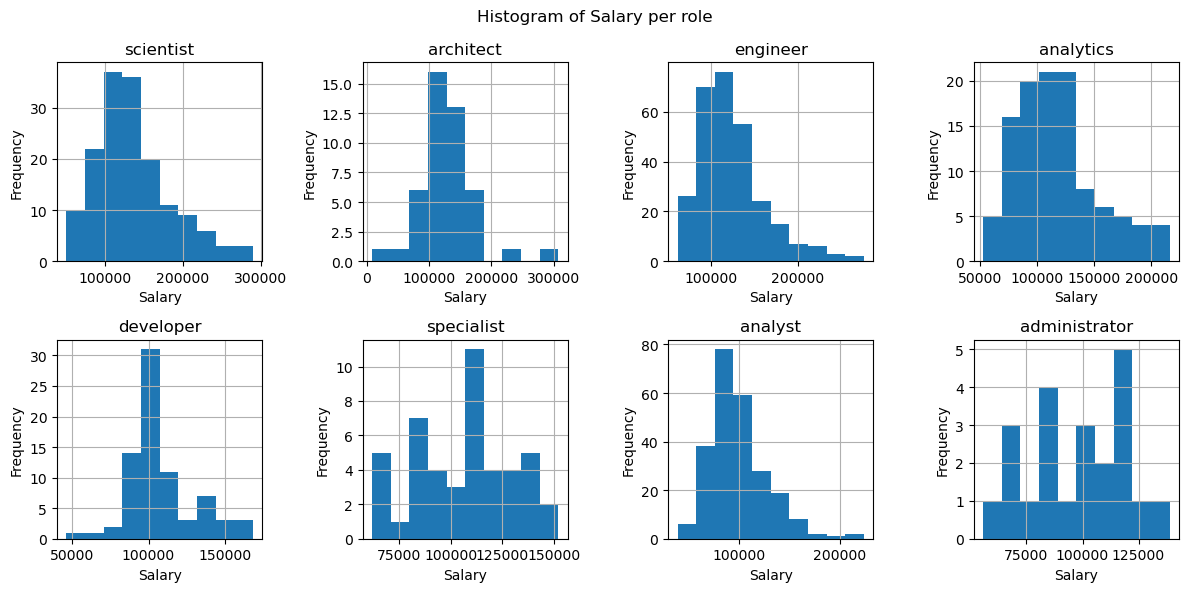

In [17]:
# Only get roles with more than 10 observations
roles_of_interests = qn3_final.loc[qn3_final['count']>10].index.to_list()

fig, axs = plt.subplots(2,4,figsize = (12,6))
fig.suptitle('Histogram of Salary per role')

for idx, role in enumerate(roles_of_interests):
    qn3_grouped\
        .loc[qn3_grouped['JOB CATEGORY'] == role, :]\
            .hist(
                ax = axs[idx//4, idx%4]
            )
    axs[idx//4, idx%4].set_title(role)
    axs[idx//4, idx%4].set_xlabel('Salary')
    axs[idx//4, idx%4].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

---

## <a id = "q5">Question 5</a>
Which company in the US has the highest rating and salary-weighted rating?



In [18]:
qn5 = df_d[["company_txt", "Job Title", "Location", "Rating", 'min_salary', 'max_salary', 'avg_salary']].copy()
qn5["Company Name"] = qn5["company_txt"].str.split("\n").str[0]
qn5 = qn5[~qn5["Company Name"].duplicated()]

max_ratings = qn5.groupby(["Company Name"])["Rating"].max()
company_with_highest_rating = max_ratings.idxmax()
highest_rating = max_ratings.max()

top_rating_companies = qn5[qn5["Rating"]==5.0]


In [19]:
for name, average_salary, location in top_rating_companies[["Company Name", "avg_salary", "Location"]].values:
    print(f"Company '{name}' located at {location}  has the highest rating of 5.0 with an average salary of ${average_salary*1000:.2f}")

Company 'BPA Services' located at Washington, DC  has the highest rating of 5.0 with an average salary of $155000.00
Company 'Gridiron IT' located at Tampa, FL  has the highest rating of 5.0 with an average salary of $132500.00
Company 'Royce Geospatial' located at Springfield, VA  has the highest rating of 5.0 with an average salary of $101000.00
Company 'SkySync' located at Ann Arbor, MI  has the highest rating of 5.0 with an average salary of $130000.00


In [20]:
qn5["salaryXrating"] = qn5["avg_salary"] * qn5["Rating"]
salary_weighted_rating = qn5.sort_values(ascending = False, by = "salaryXrating")

In [21]:
print("Companies with highest salary weighted rating \n")

for weighted_rating, name, average_salary, location, rating in salary_weighted_rating[["salaryXrating", "Company Name", "avg_salary", "Location", "Rating"]].iloc[:5].values:
    print(f"Weighted rating of {weighted_rating:.1f}: Company '{name}' located at {location}  has the rating of {rating} with an average salary of ${average_salary*1000:.2f}")

Companies with highest salary weighted rating 

Weighted rating of 1092.8: Company 'Sage Intacct' located at San Francisco, CA  has the rating of 4.7 with an average salary of $232500.00
Weighted rating of 997.5: Company 'Gallup' located at Washington, DC  has the rating of 4.2 with an average salary of $237500.00
Weighted rating of 930.3: Company 'Grand Rounds' located at San Francisco, CA  has the rating of 4.2 with an average salary of $221500.00
Weighted rating of 840.5: Company 'Credit Sesame' located at Mountain View, CA  has the rating of 4.1 with an average salary of $205000.00
Weighted rating of 789.6: Company 'Confluent' located at Mountain View, CA  has the rating of 4.7 with an average salary of $168000.00


## <a id = "q6">Question 6</a>
If I want to work in the US, which job in which location has the fastest H-1B approval time? How much is the salary for these jobs?

Will consider those with at least 30 sample size. Data limited to year 2023 - 2024 ytd.


Answer:
- Salary: Salary doesn't seem to be a factor to how fast the approval is
- Job type: Backend jobs seem to have the fastest approval
- Location: Amongst the top 10 cities which saw the fastest H1b approval, Texas appears to dominate

In [22]:
def clean_job_title_limited(title):
    title = title.lower()
    if 'data analy' in title:
        return 'Data Analyst'
    elif 'data engineer' in title:
        return 'Data Engineer'
    elif 'machine learn' in title:
        return 'Machine Learning Engineer'
    elif 'research scientist' in title:
        return 'Research Scientist'
    elif 'marketing scientist' in title:
        return 'Marketing Scientist'
    elif 'business intelligence' in title or 'bi developer' in title:
        return 'Business Intelligence (BI) Developer'
    elif 'business analyst' in title:
        return 'Business Analyst'
    elif 'data modeler' in title:
        return 'Data Modeler'
    elif 'database administrator' in title:
        return 'Database Administrator'
    elif 'data architect' in title:
        return 'Data Architect'
    elif 'statistician' in title:
        return 'Statistician'
    elif 'quantitative analyst' in title:
        return 'Quantitative Analyst'
    elif 'data governance' in title:
        return 'Data Governance'
    elif 'data scientist' in title:
        return 'Data Scientist'
    elif 'software engineer' in title:
        return 'Software Engineer'
    elif 'consultant' in title:
        return 'Consultant'
    else:
        return 'Other'

# Apply the cleaning function to the JOB TITLE column
qn6 = df_e.copy()

# Convert the SUBMIT DATE and START DATE columns to datetime format
for dt in ['SUBMIT DATE', 'START DATE']:
    qn6[dt] = pd.to_datetime(qn6[dt])

# Get only 2023 and 2024 data
qn6 = qn6.loc[qn6['START DATE'].dt.year >= 2023]

qn6['JOB TITLE'] =\
    qn6['JOB TITLE'].apply(clean_job_title_limited)

# Calculate the difference between START DATE and SUBMIT DATE
qn6['DAYS_TO_START'] = (qn6['START DATE'] - qn6['SUBMIT DATE']).dt.days

# Remove rows with negative values in DAYS_TO_START
qn6 = qn6[qn6['DAYS_TO_START'] >= 0]


In [23]:
# Define salary bins and labels
salary_bins = [0, 90000, 110000, 130000, float('inf')]
salary_labels = ['0-90k', '90k-110k', '110k-130k', '130k+']

# Create a new column for salary groups
qn6['SALARY_GROUP'] = pd.cut(qn6['BASE SALARY'], bins=salary_bins, labels=salary_labels)

# Display the grouped data
salary_group_summary = qn6.groupby('SALARY_GROUP')['DAYS_TO_START'].describe()

# Display the summary statistics
print(salary_group_summary)

               count       mean        std  min   25%   50%    75%    max
SALARY_GROUP                                                             
0-90k         4211.0  79.598433  66.595346  0.0  11.0  73.0  143.0  183.0
90k-110k      4298.0  77.075617  70.345575  0.0   8.0  47.0  151.0  183.0
110k-130k     3168.0  77.858270  72.023106  0.0  10.0  44.0  160.0  183.0
130k+         6026.0  93.311815  76.283778  0.0  12.0  97.0  177.0  183.0


C:\Users\neish\AppData\Local\Temp\ipykernel_352\3831405623.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_group_summary = qn6.groupby('SALARY_GROUP')['DAYS_TO_START'].describe()


Salary dont seem to have a relation in how fast the applicant their job

In [24]:
job_title_summary = qn6.groupby('JOB TITLE')['DAYS_TO_START'].describe()
print(job_title_summary)


                                       count        mean        std   min  \
JOB TITLE                                                                   
Business Analyst                         7.0   95.000000  65.482822   9.0   
Business Intelligence (BI) Developer    24.0   93.541667  66.061223   0.0   
Consultant                              80.0   88.262500  63.666803   0.0   
Data Analyst                          2856.0   72.921218  67.382426   0.0   
Data Architect                         367.0   59.847411  67.274689   0.0   
Data Engineer                         6396.0   75.715760  72.372917   0.0   
Data Governance                         74.0   60.500000  66.983386   0.0   
Data Modeler                            41.0   57.268293  63.897975   0.0   
Data Scientist                        5059.0   95.856493  72.710055   0.0   
Database Administrator                 167.0  137.550898  52.513413   4.0   
Machine Learning Engineer               13.0  110.230769  54.928975  11.0   

In [25]:
# Calculate the count of each job title
job_title_counts = qn6['JOB TITLE'].value_counts()

# Filter out job titles with less than 30 counts
job_titles_to_include = job_title_counts[job_title_counts >= 30].index

# Filter the dataframe to include only job titles with at least 30 counts
job_title_cleaned_data = qn6[qn6['JOB TITLE'].isin(job_titles_to_include)]

# Average 'TIME TO START' by job title (Top 10)
avg_time_to_start_job_title = job_title_cleaned_data.groupby('JOB TITLE')['DAYS_TO_START'].mean().sort_values(ascending=1).head(10)
print("Average Time to Start by Job Title (Top 10):")
print(avg_time_to_start_job_title)

Average Time to Start by Job Title (Top 10):
JOB TITLE
Data Modeler               57.268293
Data Architect             59.847411
Data Governance            60.500000
Data Analyst               72.921218
Data Engineer              75.715760
Consultant                 88.262500
Other                      89.354465
Data Scientist             95.856493
Database Administrator    137.550898
Name: DAYS_TO_START, dtype: float64


Backend data jobs such as Data architect, data engineer have the fastest approval time

In [26]:
# Calculate the count of each job title
Location_counts = qn6['LOCATION'].value_counts()
# Filter out job titles with less than 30 counts
Location_to_include = Location_counts[Location_counts >= 30].index

# Filter the dataframe to include only job titles with at least 30 counts
Location_cleaned_data = qn6[qn6['LOCATION'].isin(Location_to_include)]

# Average 'TIME TO START' by job title (Top 10)
avg_time_to_start_Location = Location_cleaned_data.groupby('LOCATION')['DAYS_TO_START'].mean().sort_values(ascending=1).head(10)
print("Average Time to Start by Job Title (Top 10):")
print(avg_time_to_start_Location)

Average Time to Start by Job Title (Top 10):
LOCATION
LEWISVILLE, TX        45.973684
FARMERS BRANCH, TX    47.314815
EDISON, NJ            49.775510
MCKINNEY, TX          54.648649
PLANO, TX             54.911175
CUMMING, GA           55.611940
SCOTTSDALE, AZ        56.718750
DURHAM, NC            56.735849
MCLEAN, VA            57.568182
MEMPHIS, TN           57.717949
Name: DAYS_TO_START, dtype: float64


These are the top 10 locations in terms of approval time

---

## <a id = "q7">Question 7</a>

How has data-related jobs grown over the years?

Answer:
- Overall, data-related roles saw a growth from mid 2010s till 2022, and have since started to decline
- Average salary of data-related roles has increased slightly in recent years
- Job prospects for data analysts have stagnated, with the annual salary starting to reduce
- Job prospects for data scientist have remained constant, with marginal increase in annual salary
- Despite decreasing hiring activities for other data roles, the salary increment is the highest for this segment.

In [27]:
qn7 = df_e.copy()
employer_list = pd.DataFrame(df_e['EMPLOYER'].value_counts())
percentile80 = employer_list['count'].quantile(0.8)
frequent_employers = employer_list.loc[employer_list['count']>percentile80]

print(f"Total number of jobs, after considering only frequent employers: {int(frequent_employers['count'].sum())}")
print(f"Percentage to total jobs: {frequent_employers['count'].sum() / employer_list['count'].sum():.2%}")


Total number of jobs, after considering only frequent employers: 74691
Percentage to total jobs: 76.15%


In [28]:
df_freq_employers = df_e.loc[df_e['EMPLOYER'].isin(frequent_employers.index),:].copy().reset_index(drop = True)
df_freq_employers['CITY'], df_freq_employers['STATE'] = zip(*df_freq_employers['LOCATION'].str.split(','))
df_freq_employers['POSTING YEAR'] = df_freq_employers['SUBMIT DATE'].dt.year
df_freq_employers['POSTING MONTH'] = df_freq_employers['SUBMIT DATE'].dt.to_period('M')
df_freq_employers['START MONTH'] = df_freq_employers['START DATE'].dt.to_period('M')
df_freq_employers['DAYS AHEAD'] = (df_freq_employers['START DATE'] - df_freq_employers['SUBMIT DATE']).dt.days

df_freq_employers.head()

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,ROLE CLASSIFICATION,CITY,STATE,POSTING YEAR,POSTING MONTH,START MONTH,DAYS AHEAD
0,NEUBERGER BERMAN GROUP LLC,DATA PLATFORM DATA ANALYST,120000.0,"NEW YORK, NY",2015-07-06,2015-07-10,data analyst,NEW YORK,NY,2015,2015-07,2015-07,4
1,IBM CORPORATION,DATA SCIENTIST,71032.0,"CLEVELAND, OH",2015-10-30,2015-11-06,data scientist,CLEVELAND,OH,2015,2015-10,2015-11,7
2,IBM INDIA PRIVATE LIMITED,DATA SPECIALIST,64641.0,"BENTONVILLE, AR",2015-11-09,2016-05-09,other data roles,BENTONVILLE,AR,2015,2015-11,2016-05,182
3,INFOGROUP INC,DATABASE DEVELOPER,105000.0,"PAPILLION, NE",2015-03-07,2015-09-05,other data roles,PAPILLION,NE,2015,2015-03,2015-09,182
4,INFOGROUP INC,DATABASE DEVELOPER,115000.0,"BURLINGTON, MA",2015-12-11,2016-05-14,other data roles,BURLINGTON,MA,2015,2015-12,2016-05,155


In [29]:
def plot_job_growth(df, role_class = None):
    if role_class:
        df_tmp = df.loc[df['ROLE CLASSIFICATION']==role_class].copy()
    else:
        df_tmp = df.copy()

    ts_jobs = df_tmp\
        .groupby(by = ['POSTING MONTH'])\
            .agg(
                nbr_posts = ('JOB TITLE','count'),
                avg_salary = ('BASE SALARY','mean'),
                std_salary = ('BASE SALARY','std') ).fillna(0)

    ts_jobs['upp_salary'] = ts_jobs['avg_salary'] + ts_jobs['std_salary']
    ts_jobs['low_salary'] = ts_jobs['avg_salary'] - ts_jobs['std_salary']

    role_class = "DATA" if not role_class else role_class
    fig, axs = plt.subplots(2,1,figsize = (12,6),sharex = True)
    ts_jobs['nbr_posts'].plot(title = f'Number of postings on {role_class} job over the years', ax = axs[0], label = 'Actual', color = 'k')
    ts_jobs['nbr_posts'].rolling(window = 12, min_periods = 1).mean().plot(ax = axs[0], ls = '--', color = 'red', label = 'Rolling 12M')
    axs[0].grid()
    axs[0].legend()
    ts_jobs['avg_salary'].plot(title = 'Average base salary ($) over the years', ax = axs[1])
    ts_jobs['avg_salary'].rolling(window = 12, min_periods = 1).mean().plot(ax = axs[1], ls = '--', color = 'red', label = 'Rolling 12M')
    axs[1].fill_between(ts_jobs['upp_salary'].index, ts_jobs['upp_salary'], color='skyblue')#, alpha=0.2)
    axs[1].fill_between(ts_jobs['low_salary'].index, ts_jobs['low_salary'], color='white')
    axs[1].grid()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

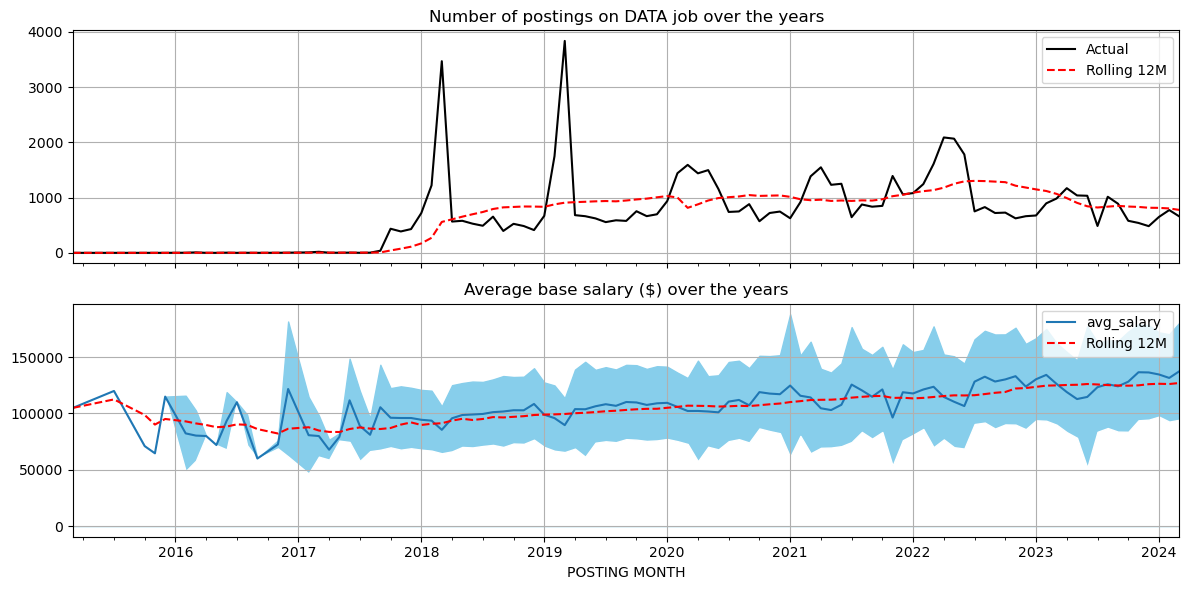

In [30]:
plot_job_growth(df_freq_employers)

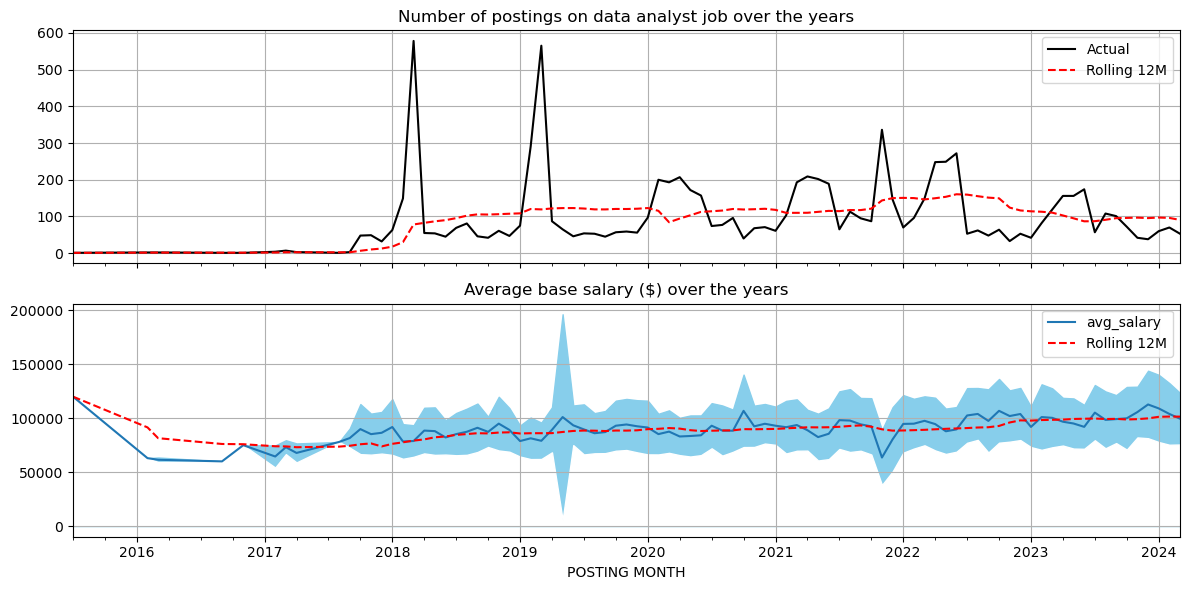

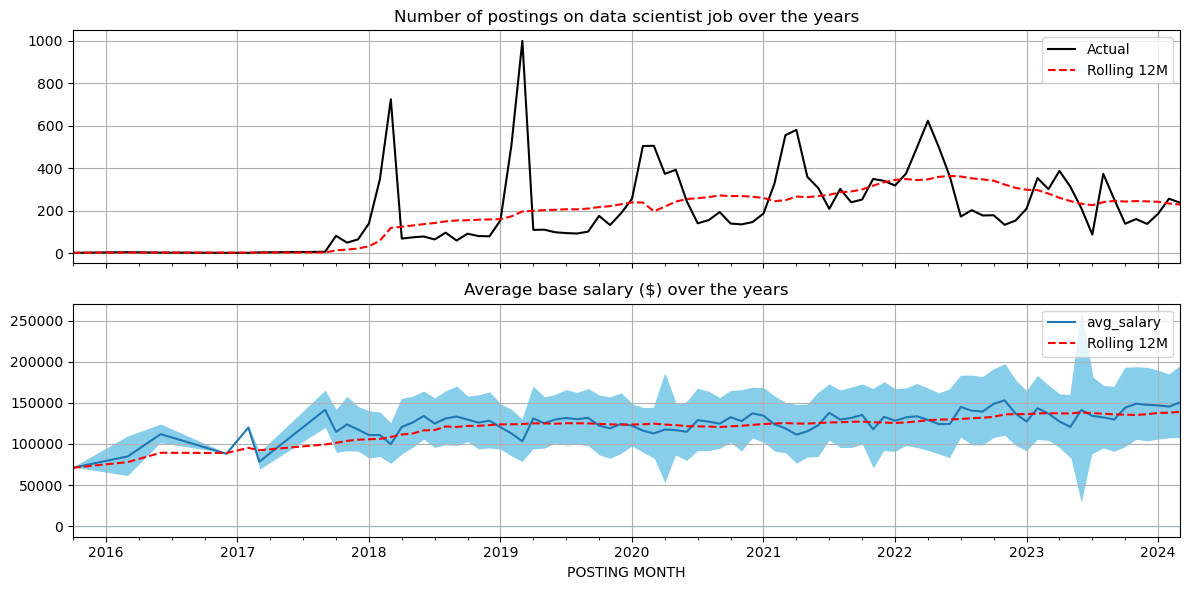

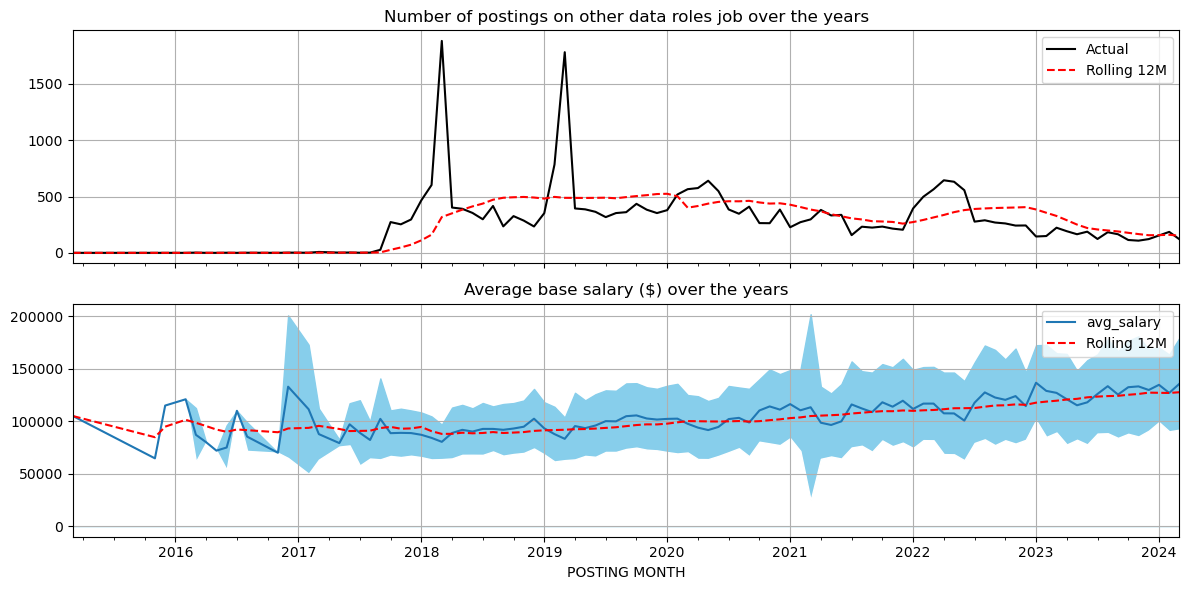

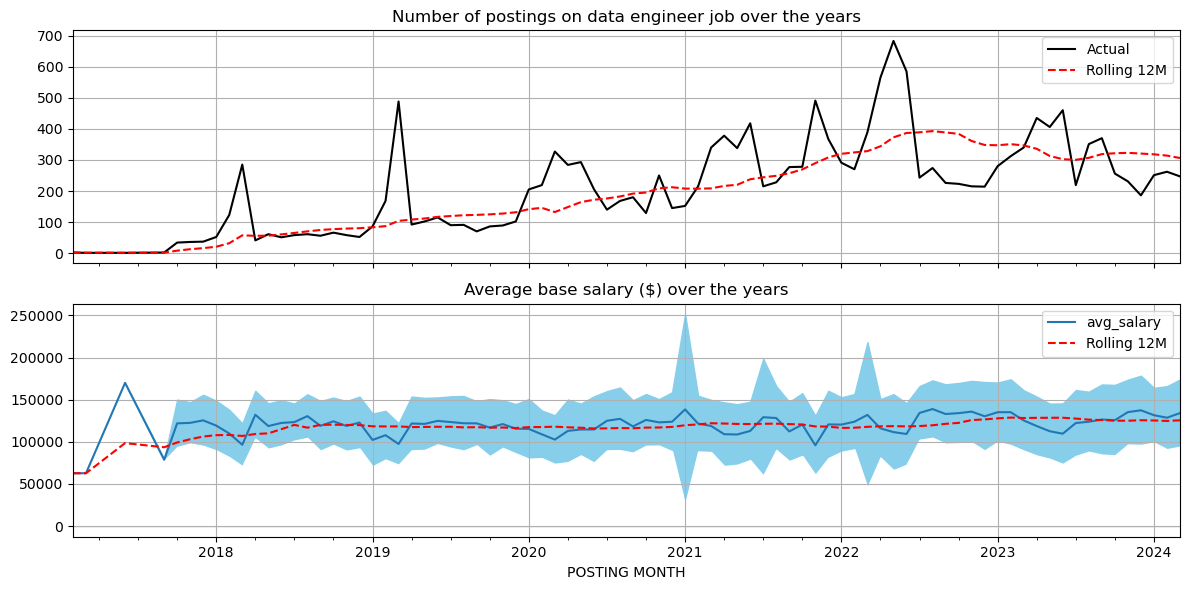

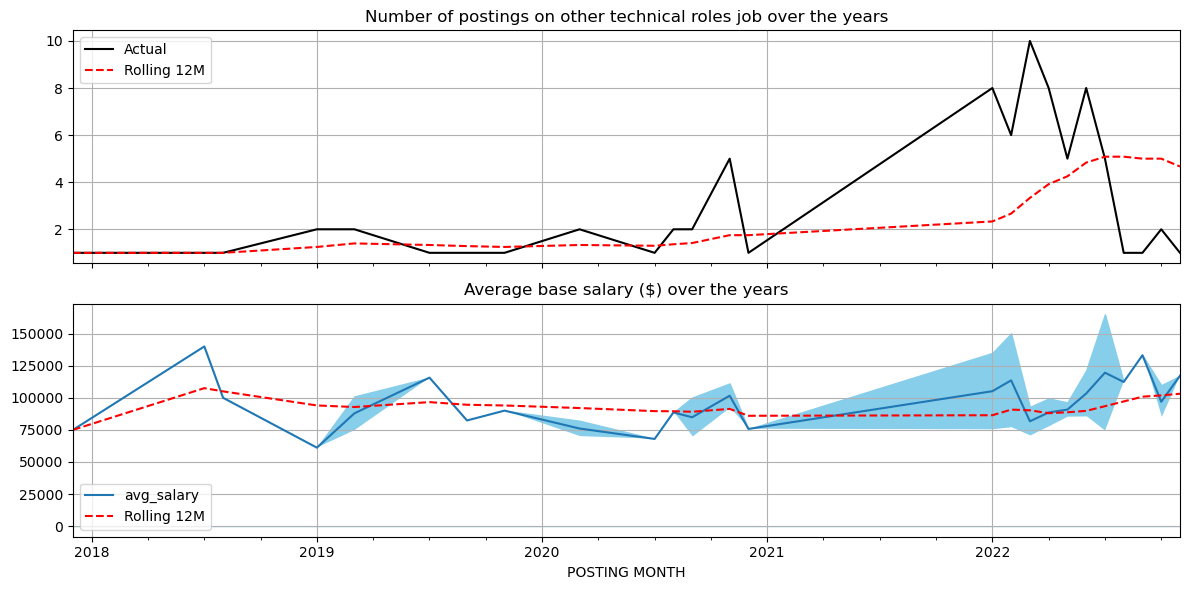

In [31]:
for role in df_freq_employers['ROLE CLASSIFICATION'].unique():
    plot_job_growth(df_freq_employers, role)